In [1]:
import numpy as np
import pickle
import seaborn as sns
import itertools
from pylab import *
from multiprocessing import Pool
%matplotlib inline

In [2]:
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

In [3]:
!pwd

/home/ibis/gregor.sturm/nanopore/own/notebooks


In [4]:
# args = {
#     "all_events": "/home/ibis/gregor.sturm/nanopore/own/notebooks/03_pipeline/david_events.{0}.pickle"
# }
args = {
    "all_events": "/home/ibis/gregor.sturm/nanopore/own/notebooks/03_pipeline/lambda_events.{0}.pickle",
    "ncores": 40
}

In [5]:
all_evs = {}
TYPES = ["template", "complement", "2D"]
for t in TYPES:
    all_evs[t] = pickle.load(open(args["all_events"].format(t), 'rb'))

In [6]:
all_evs["template"][0]

{'channel': 101,
 'events':           end   kmer       mean  move    start      stdv
 0      973006  CGTTC  44.855114     0   972817  0.682305
 1      973032  GTTCT  48.555570     1   973007  0.537994
 2      973139  TTCTT  58.581036     1   973033  0.896115
 3      973167  TCTTC  52.644896     1   973140  1.225819
 4      973229  CTTCT  50.682698     1   973168  1.716593
 5      973262  TTCTT  59.607426     1   973230  1.318665
 6      973397  TCTTC  51.376330     1   973263  0.878068
 7      973414  CTTCG  55.762980     1   973398  1.264391
 8      973449  TTCGT  63.809543     1   973415  1.292451
 9      973516  TCGTC  59.029648     1   973450  1.943214
 10     973546  GTCTC  57.374503     2   973517  0.676752
 11     973622  TCTCT  60.914672     1   973547  0.748625
 12     973654  CTCTC  61.653040     1   973623  0.546477
 13     973706  TCTCT  60.587832     1   973655  0.816212
 14     973764  CTCTG  64.241289     1   973707  1.196290
 15     973794  TCTGG  59.045286     1   9737

In [7]:
medians_t = [file_obj["events"]["mean"].median() for file_obj in all_evs["template"]]
medians_c = [file_obj["events"]["mean"].median() for file_obj in all_evs["complement"]]

(40, 100)

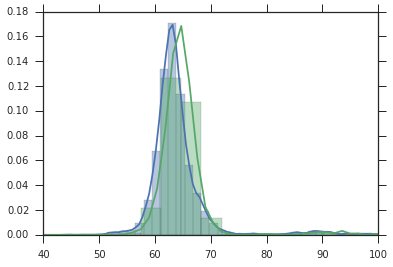

In [8]:
fig, ax = subplots()
sns.distplot(medians_t, ax=ax)
sns.distplot(medians_c, ax=ax)
ax.set_xlim((40, 100))


In [9]:
CHAN = [33, 450, 451, 19, 30, 20, 467, 9, 13, 452]
CHAN = CHAN[0]

In [10]:
channel_events = sorted([f for f in all_evs["2D"] if f["channel"] == CHAN], key=lambda x: x["file_id"])

In [11]:
current_over_time = [f["events"]["template.mean"].median() for f in channel_events]
current_over_time_c = [f["events"]["complement.mean"].median() for f in channel_events]

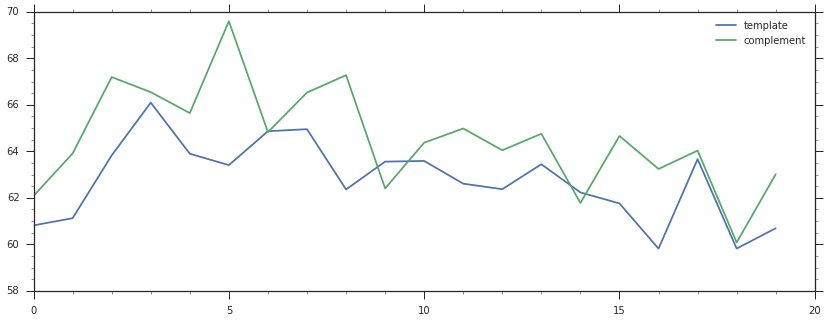

In [12]:
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(current_over_time, label="template")
ax.plot(current_over_time_c, label="complement")
ax.minorticks_on()
ax.legend()

In [13]:
divergence = [f["events"]["template.mean"].median() - f["events"]["complement.mean"].median() for f in all_evs["2D"]]

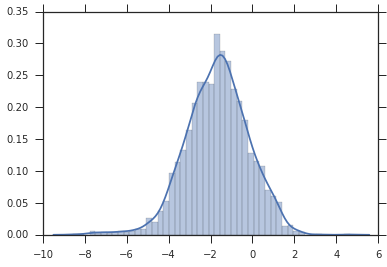

In [14]:
sns.distplot(divergence)
#, bins=np.arange(-8, 4, .5)

In [15]:
def event_median(f_obj, type):
    def median_2d(f_obj):
#         return np.nanmedian(f_obj["events"]["template.mean"].tolist()
#                                   + f_obj["events"]["complement.mean"].tolist())
        return f_obj["events"]["template.mean"].median()

    def median_1d(f_obj):
        return f_obj["events"]["mean"].median()
    
    fx = {
        "2D": median_2d,
        "template": median_1d,
        "complement": median_1d
    }
    return fx[type](f_obj)

In [16]:
def filter_reads(all_events, median, deviation, type):
    """
    select reads that are within +-deviation of median
    """
    return [fo for fo in all_events if median-deviation < event_median(fo, type) < median+deviation]

In [17]:
def normalize_read(args):
    """normalize all events to a given median"""  
    f_obj, median, t = args
    tmp_median = event_median(f_obj, t)
    factor = median/tmp_median
    
    fields = {
        "2D": ["template.mean", "complement.mean", "template.stdv", "complement.stdv"],
        "template": ["mean"],
        "complement": ["mean"]
    }
    
    for f in fields[t]: 
        f_obj["events"][f] = f_obj["events"][f].map(lambda x: x*factor)
        
    return f_obj

In [18]:
event_data = {}
MEDIAN = 62

In [19]:
for t in TYPES: 
    event_data[t] = filter_reads(all_evs[t], MEDIAN, 1, t)
    print(t, len(event_data[t]), len(all_evs[t]))

template 1802 6123
complement 613 3326
2D 746 2872


In [20]:
print(event_data["2D"][5]["events"]["template.mean"].median())
print(event_data["2D"][5]["events"]["complement.mean"].median())
print(event_data["template"][5]["events"]["mean"].median())
print(event_data["complement"][5]["events"]["mean"].median())

60.9795653203708
63.76271428034856
62.429906862394944
62.586859728495284


In [26]:
p = Pool(args["ncores"])
event_data_norm = {}
for t in TYPES:
    print(t)
    try:
        event_data_norm[t] = p.map(normalize_read, zip(event_data[t], itertools.repeat(MEDIAN), itertools.repeat(t)))
    except KeyboardInterrupt:
        p.terminate()

template
complement
2D


In [27]:
print(event_data_norm["2D"][5]["events"]["template.mean"].median())
print(event_data_norm["2D"][5]["events"]["complement.mean"].median())
print(event_data_norm["template"][5]["events"]["mean"].median())
print(event_data_norm["complement"][5]["events"]["mean"].median())

61.26419383477385
64.06033343431551
62.0
62.0


In [28]:
for t in TYPES:
    pickle.dump(event_data_norm[t], open(args["all_events"].format("{0}.62pA".format(t)), 'wb'), protocol=2)